# Classifying Higher-Priced Mortgage Loan 

### Interpretable Machine Learning 

---

## Seungheon Han


In [350]:
from platform import python_version

print(python_version())

3.8.3


In [1]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import subprocess                                                 # to run external processes for model extraction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from scipy import stats
import time
import xgboost as xgb
import itertools
import datetime
import copy 
from sklearn.metrics import accuracy_score, f1_score
import random

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

# set seed
SEED = 12345
np.random.seed(SEED)
# set number of threads
NTHREAD = 4

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display                                               

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.11" 2021-04-20 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.11+9-LTS-194); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.11+9-LTS-194, mixed mode)
  Starting server from /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/nx/cr2rq5412hv8xlv04b3g1qn00000gn/T/tmpku375oxi
  JVM stdout: /var/folders/nx/cr2rq5412hv8xlv04b3g1qn00000gn/T/tmpku375oxi/h2o_alex_started_from_python.out
  JVM stderr: /var/folders/nx/cr2rq5412hv8xlv04b3g1qn00000gn/T/tmpku375oxi/h2o_alex_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_alex_40s8n6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


# 0. Import data & Assign basic modeling roles

In [2]:
#change directory where the data files are located

%cd /Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset/

/Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset


In [3]:
# load train and test data sets

tr_df = pd.read_csv("hmda_train_preprocessed.csv") # the given training data set
test = pd.read_csv("hmda_test_preprocessed.csv") # the given test data set

In [4]:
# basic information on the data set 
tr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160338 entries, 0 to 160337
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   row_id                        160338 non-null  int64  
 1   black                         137790 non-null  float64
 2   asian                         137790 non-null  float64
 3   white                         137790 non-null  float64
 4   amind                         137790 non-null  float64
 5   hipac                         137790 non-null  float64
 6   hispanic                      137877 non-null  float64
 7   non_hispanic                  137877 non-null  float64
 8   male                          86537 non-null   float64
 9   female                        86537 non-null   float64
 10  agegte62                      81414 non-null   float64
 11  agelt62                       81414 non-null   float64
 12  term_360                      160338 non-nul

In [5]:
# assign reponse and predictors 
y_name = "high_priced"
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

# 1. Data Exploration & Preprocessing

## 1.1 histogram for discerining data distribution across the features 

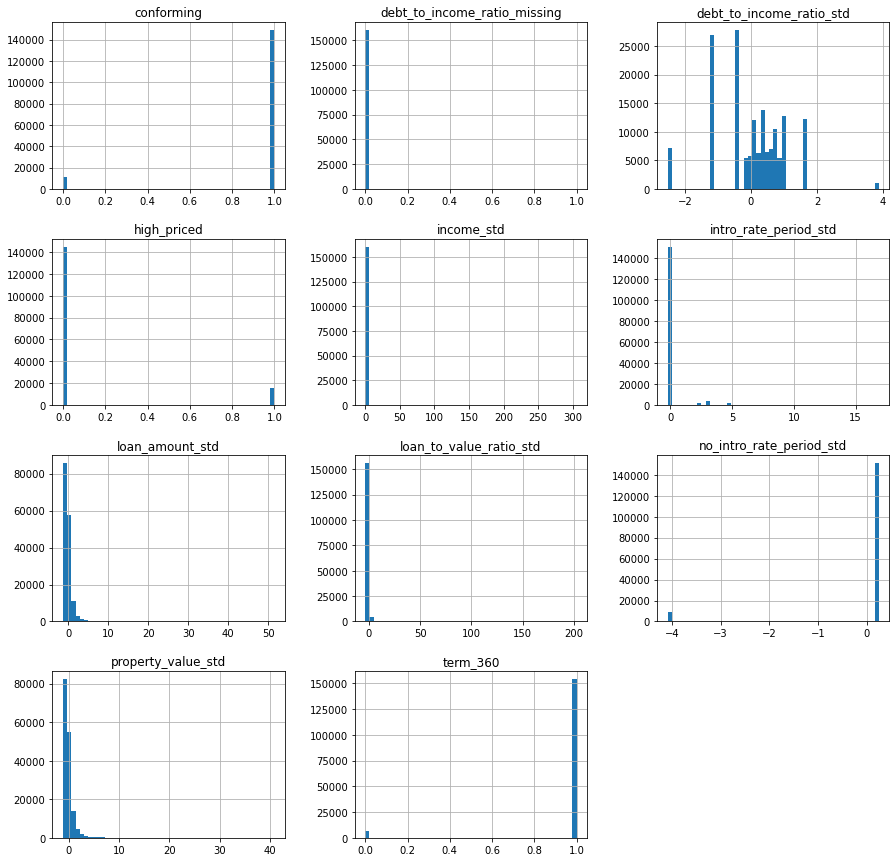

In [6]:
# Histograms
_ = tr_df[x_names + [y_name]].hist(bins=50, figsize=(15, 15))

## 1.2 heat map for the diagnosis for multicollinearity 

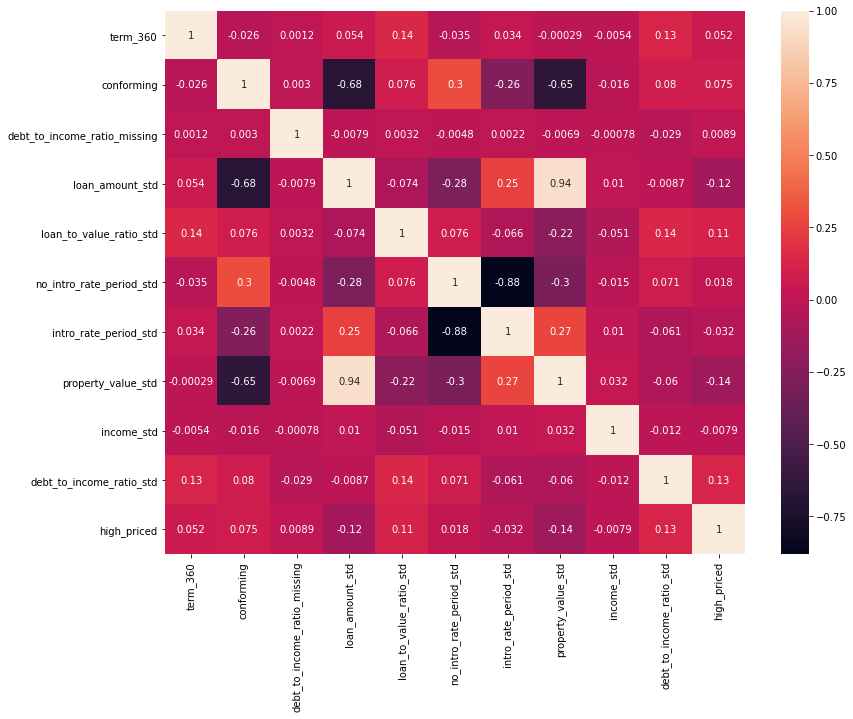

In [7]:
# Check Multicollinearity 
plt.figure(figsize = (13,10))

corr = tr_df[x_names + [y_name]].corr()
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values, annot = True)

### creating an interaction feature

In [8]:
# loan_amount_std & property_value_std are highly correlated with the correlation 0.94. 
# Generate a new interaction feature by multiplying the two features
tr_df["loan_amt:prprty_vl"] = tr_df["loan_amount_std"]*tr_df["property_value_std"]
test["loan_amt:prprty_vl"] = test["loan_amount_std"]*test["property_value_std"]

In [9]:
# Add the new feature to the x_names list
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
          'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std', 'loan_amt:prprty_vl']

# continous variables
cont_feature = ["loan_amount_std", "loan_to_value_ratio_std", "no_intro_rate_period_std", "intro_rate_period_std", "property_value_std", "income_std", "debt_to_income_ratio_std", 'loan_amt:prprty_vl']

## 1.3 box plots for outlier detection

In [10]:
# in order to draw the box plots of all the features in the same y-axis, scale the variables
scaled_tr = pd.DataFrame(scale(tr_df[cont_feature]), columns = cont_feature)

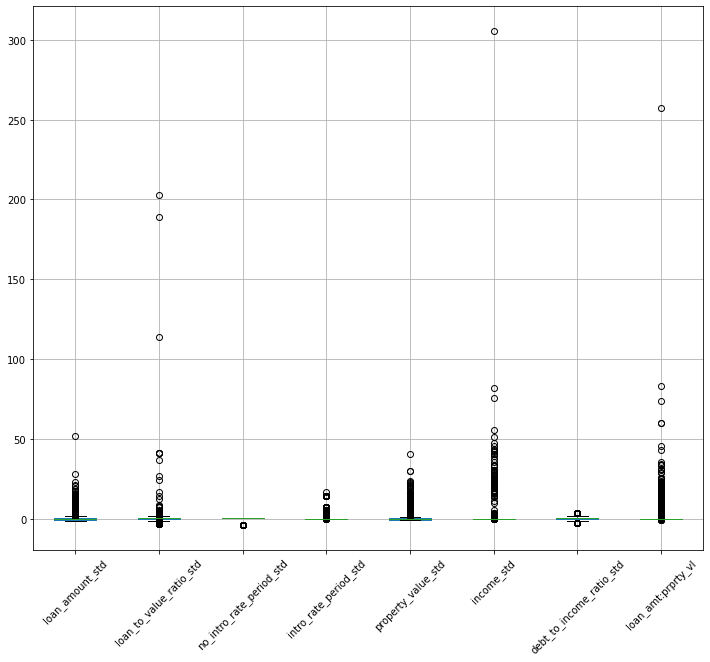

In [11]:
# box plots for the continous variables 
plt.figure(figsize=(12, 10))

scaled_tr.boxplot()
plt.xticks(rotation=45)
plt.show()

* "loan_amount_std", "loan_to_value_ratio_std", "income_std", "loan_amt:prprty_vl" seem to have significant outliers.
* According to the shapley value, "loan_to_value_ratio_std" is the most important feature in the MXGB & EBM models.
* So, primarily detect the outliers of the "loan_to_value_ratio_std" feature and remove the ourlier rows.

### outliers (|z-score| > 3)

In [12]:
def detect_outlier(var_list):
    
    threshold=3
    outliers = []
    
    for col in var_list:
        
        mean1 = np.mean(tr_df[col])
        std1 =np.std(tr_df[col])
        
        for x in tr_df[col]:
            
            # calculate the z-score
            z_score = (x - mean1)/std1
            
            if np.abs(z_score) > threshold:
                
                # find the index of the outlier row 
                if tr_df.index[tr_df[col] == x].tolist() not in outliers:
                    
                    outliers.append(tr_df.index[tr_df[col] == x].tolist())       
           
    return outliers

In [13]:
# delete the ourlier rows from the whole training set
var_list = ["loan_to_value_ratio_std"]
outliers_list = detect_outlier(var_list)

orgl_len = len(tr_df)

for i in outliers_list:
    tr_df = tr_df.drop(index = i, axis = 0)

deleted_rows = orgl_len - len(tr_df)
print("the number of deleted rows: %d" % deleted_rows)

the number of deleted rows: 166


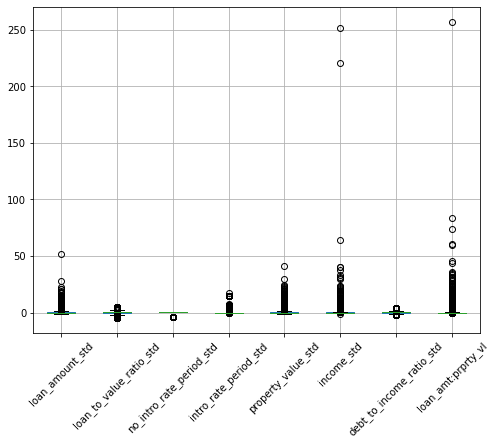

In [14]:
# double check box plots  

scaled_tr = pd.DataFrame(scale(tr_df[cont_feature]), columns = cont_feature)
plt.figure(figsize=(8, 6))

scaled_tr[cont_feature].boxplot()
plt.xticks(rotation=45)
plt.show()

## 1.4 null values

In [15]:
# Check null values 
tr_df[x_names+[y_name]].isnull().sum() # no null-value is detected

term_360                        0
conforming                      0
debt_to_income_ratio_missing    0
loan_amount_std                 0
loan_to_value_ratio_std         0
no_intro_rate_period_std        0
intro_rate_period_std           0
property_value_std              0
income_std                      0
debt_to_income_ratio_std        0
loan_amt:prprty_vl              0
high_priced                     0
dtype: int64

## 1.5 Split train & validation sets

In [16]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.7 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(tr_df)) < ratio # define indices of 70% corresponding to the training set

train = tr_df[split]
valid = tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112146, columns = 24
Validation data rows = 48026, columns = 24


# 2. Modeling

## 2.1 XGBoosting Machine

### Random Grid Search for XGBoost

In [17]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

### Fit XGBoost

In [18]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7], 
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(train[x_names], train[y_name])
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])

# Monotonic XGBoost grid search                        
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/50: 0.7919.
---------- ----------
Grid search run 2/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 3/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_byt

Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 40/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1, -1)}
---------- ----------
Grid search run 41/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_

### AUC assessment (MXGB)

In [19]:
# Print AUC of the best trained model
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7943.


### Model Score (Prediction on test set)

In [160]:
dtest = xgb.DMatrix(test[x_names])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit.to_csv('/Users/alex/Desktop/Responsible_ML/score/group7_XGBoost2.csv', index=False)

## 2.2 Explainable Boosting Machine (EBM)


### Random Grid Search for EBM

In [72]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

### Fit EBM

In [21]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8286.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

### AUC assessment (EBM)

In [22]:
# Print AUC of the best trained model 
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8308.


### Model Score (Prediction on test set)

In [23]:
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1], columns=['phat'])
best_ebm_submit.to_csv('/Users/alex/Desktop/Responsible_ML/score/group7_EBM3.csv', index=False)

### -----------------------------------------------------------------------------------------------------------

# 3. Feature Importance

## 3.1 Global feature importance

### Scoring validation data with MXGB model

In [23]:
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat = pd.concat([valid[["row_id"] + x_names].reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_amt:prprty_vl,phat
0,0,1,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0.275680,0.260846
1,6,1,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0.202249,0.255681
2,8,1,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0.030925,0.031577
3,10,1,1,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0.122426,0.022144
4,11,1,1,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0.011296,0.007861


### XGB model: Shapley values

In [24]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))

In [25]:
shap_contribs_matrix = np.matrix(shapley_contribs)
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 1.4596663e-02  1.1183560e-04  0.0000000e+00 ...  2.4528427e-01
  -2.2497427e-02 -2.2938163e+00]
 [ 1.6952289e-02  1.3757548e-04  0.0000000e+00 ...  2.9671818e-01
   4.9772725e-02 -2.2938163e+00]
 [ 2.0146215e-02  1.8503731e-04  0.0000000e+00 ... -6.4161174e-02
   2.4657550e-01 -2.2938163e+00]
 ...
 [ 2.9390533e-02  6.8145362e-04  0.0000000e+00 ... -1.5919207e-01
   2.9367653e-01 -2.2938163e+00]
 [ 1.8775254e-02  1.1532662e-03  0.0000000e+00 ...  5.2013600e-01
   3.3654198e-01 -2.2938163e+00]
 [-1.7061583e+00  2.2941407e-04  0.0000000e+00 ... -6.3990605e-01
   3.2287329e-01 -2.2938163e+00]]

Shapley contributions rows = 48026, columns = 12


* shapley values are calculated on each and every single row of each column:
* the matrix contains the Shapley values of which rows and columns are equal to the validation set + intercept column


### Mean Abs Shapley values 

* the average absolute Shapley value for each input feature


In [26]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_names + ['intercept'])
global_fi = pd.DataFrame(np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean(), columns = ['MXGB Importance'])
print(global_fi)

                              MXGB Importance
term_360                             0.079645
conforming                           0.000933
debt_to_income_ratio_missing         0.000000
loan_amount_std                      0.401844
loan_to_value_ratio_std              0.925151
no_intro_rate_period_std             0.003006
intro_rate_period_std                0.052733
property_value_std                   0.309822
income_std                           0.019649
debt_to_income_ratio_std             0.327328
loan_amt:prprty_vl                   0.222814


### Bar chart on the Shapley values

Text(0, 0.5, 'Features')

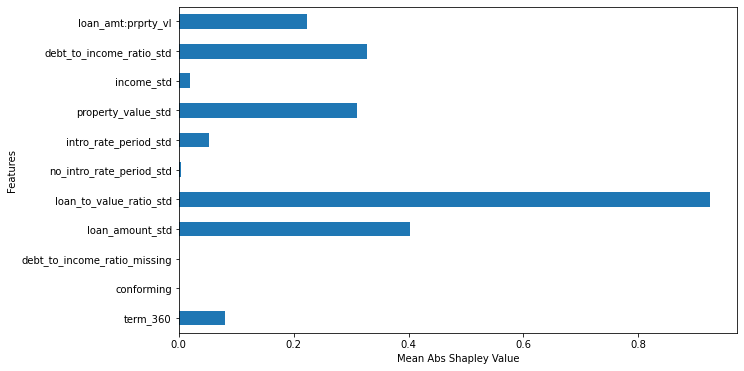

In [27]:
# plot bar chart on the global_fi to see the global feature importance
fig, ax = plt.subplots(figsize=(10,6))
global_fi["MXGB Importance"].plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Mean Abs Shapley Value')
ax.set_ylabel('Features')

### EBM: Feature score 

### Score validation data with model

In [28]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,loan_amt:prprty_vl,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.275680,0.164693
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.202249,0.325060
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.030925,0.027623
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.122426,0.016144
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.011296,0.003366


### Calculate EBM contributions

In [29]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, -1), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

EBM contributions collected in 60.65 s.


### Collect global feature importance info

In [30]:
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()
print(global_fi)

                              MXGB Importance  EBM Importance
term_360                             0.079645        0.085590
conforming                           0.000933        0.038508
debt_to_income_ratio_missing         0.000000        0.000955
loan_amount_std                      0.401844        0.335938
loan_to_value_ratio_std              0.925151        0.899126
no_intro_rate_period_std             0.003006        0.057449
intro_rate_period_std                0.052733        0.110178
property_value_std                   0.309822        0.367379
income_std                           0.019649        0.182688
debt_to_income_ratio_std             0.327328        0.387353
loan_amt:prprty_vl                   0.222814        0.118004


### Plot the feature importance of EBM model

Text(0, 0.5, 'Features')

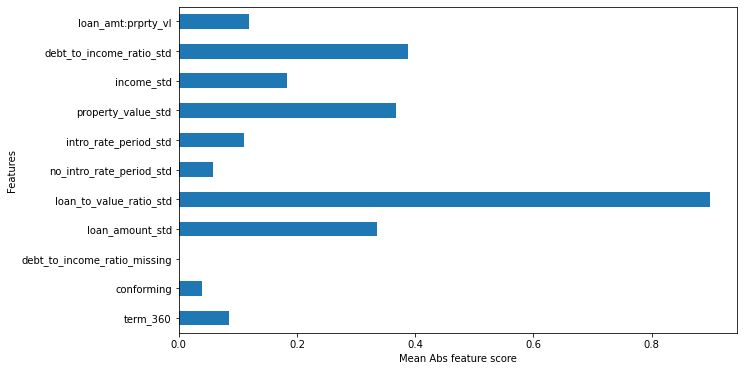

In [31]:
# plot bar chart on the global_fi to see the global feature importance
fig, ax = plt.subplots(figsize=(10,6))
global_fi["EBM Importance"].plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Mean Abs feature score')
ax.set_ylabel('Features')

### Comparing global feature importance across the two models

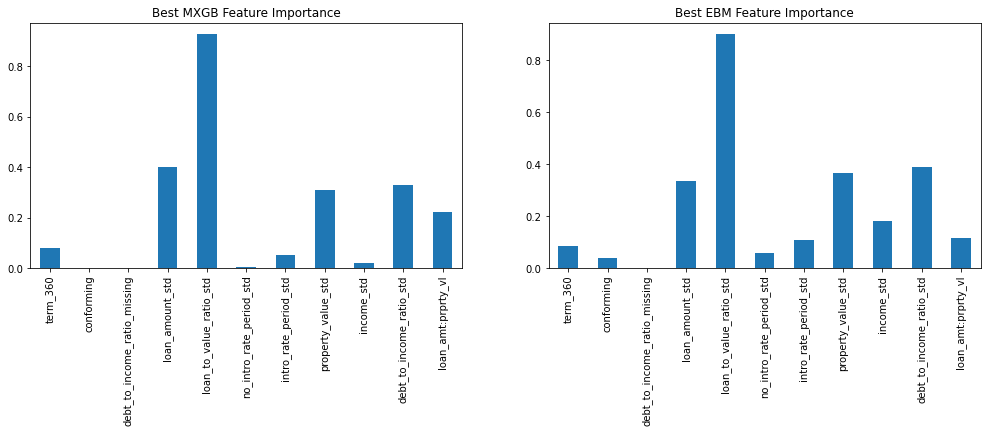

In [32]:
# init 3-pane plot 
fig, (ax0, ax1) = plt.subplots(ncols=2)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_fi['MXGB Importance'].plot(kind='bar', ax=ax0, title='Best MXGB Feature Importance')
_ = global_fi['EBM Importance'].plot(kind='bar', ax=ax1, title='Best EBM Feature Importance')

* "loan_to_value_ratio_std" is commonly shared between the two models as the most important feature in terms of predicting the response "high_priced".


* "loan_amount_std" is treated as the secondly significant variable in the MXGB model whereas the EBM model poses more importance on "debt_to_income_ratio_std" feature in generating the outcome. 


* the added new variable "loan_amt:prpty_vl" in EBM model is not considered as an important feature as in the MXGB.


* the strongest influence of LTV on the decision on higher-priced mortgage loan can make sufficient sense in the context. The borrowers whose property is given higher value can afford to borrow mortgage loans with higher APR. 


## 3.2 Local feature importance

### Select percentiles from the predictions 

In [33]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

### Calculate percentiles for MXGB & EBM respectively 

In [34]:
# percentiles for MXGB 
print("percentiles for MXGB")
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_phat, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))
    
# percentiles for ebm
print("percentiles for EBM")
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

percentiles for MXGB
0: 53870
10: 52955
20: 122665
30: 104862
40: 115961
50: 58866
60: 100013
70: 36030
80: 117520
90: 12365
99: 75300
percentiles for EBM
0: 112323
10: 125755
20: 31107
30: 102494
40: 159146
50: 121331
60: 113544
70: 51863
80: 65738
90: 91934
99: 117445


### Collect local feature importance info for XGBM & EBM

In [35]:
# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['MXGB Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['MXGB Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['MXGB Contribution'], index=x_names)}


# Local feature importance info for MXGB
# create mapping between validation row_id and Shapely array index values
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_names)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

    
# Local feature importance info for EBM
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

In [36]:
local_fi_dict

{10:                               MXGB Contribution  EBM Contribution
 term_360                              -1.345277          0.044624
 conforming                             0.000166         -0.267079
 debt_to_income_ratio_missing           0.000000         -0.000420
 loan_amount_std                        0.439418         -0.692097
 loan_to_value_ratio_std               -1.527126         -1.005841
 no_intro_rate_period_std               0.000531         -0.030566
 intro_rate_period_std                  0.012003          0.030359
 property_value_std                     0.256436          0.007515
 income_std                            -0.171066          0.221610
 debt_to_income_ratio_std              -0.251063          0.331871
 loan_amt:prprty_vl                    -0.049594         -0.063302,
 50:                               MXGB Contribution  EBM Contribution
 term_360                               0.019281          0.044624
 conforming                             0.000939     

### Compare local feature importance across models

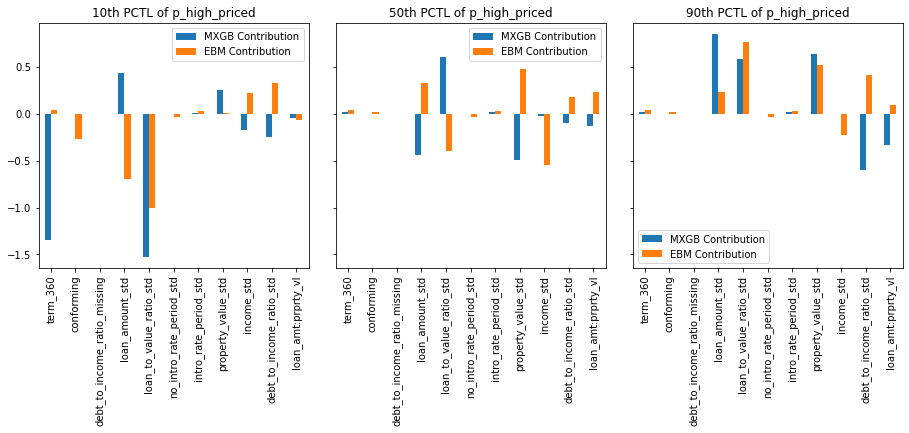

In [37]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

* For both MXGB and EBM models, the most important features seem distinct across the three percentile sections
* In addition, the significant features across the three percentile sections are different by models

# 4. Feature behavior

## 4.1 Partial dependence (global feature behavior)

### Utility function for partial dependence (for MXGB & EBM)

In [38]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

### Calculate partial dependence for all X and models

In [39]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
   
    print('Calculating partial dependence for %s ...' % name)
   
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    # calculate par dep for xgb
    pd_dict[name] = pd.DataFrame(columns=[name, 'xgb', 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_mxgb, 'xgb')
    pd_dict[name][name] = first_pd[name] 
    bins = first_pd[name]
    pd_dict[name]['xgb'] = first_pd['partial_dependence']
   
    # calculate par dep for ebm
    pd_dict[name]['ebm'] = par_dep(name, valid[x_names], best_ebm, 'ebm', bins=bins)['partial_dependence']
   
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for loan_amt:prprty_vl ...
Done.
Partial dependence calculated in 63.31 s.


### Comparing partial dependence for all features across the two models


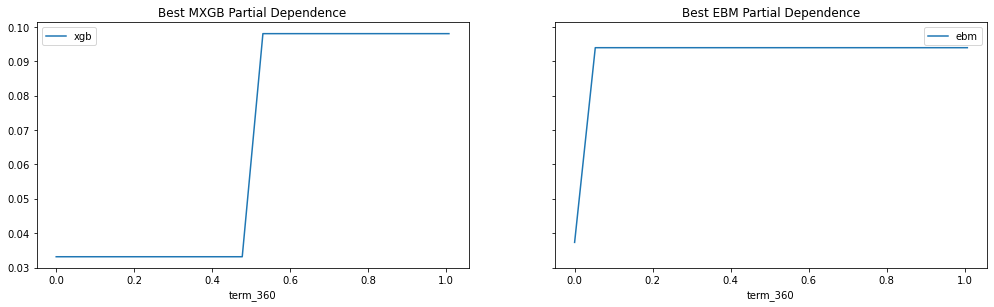

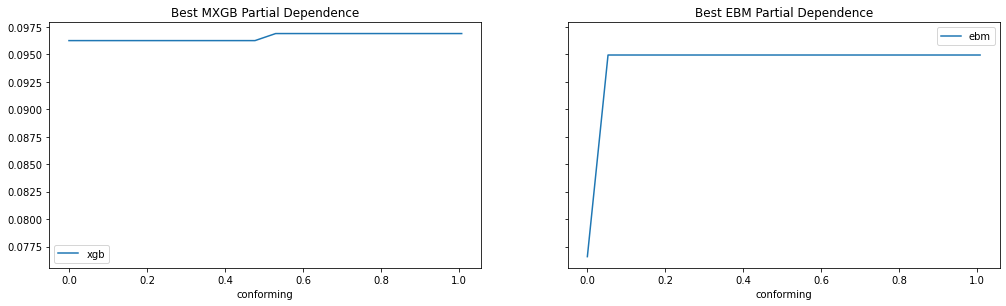

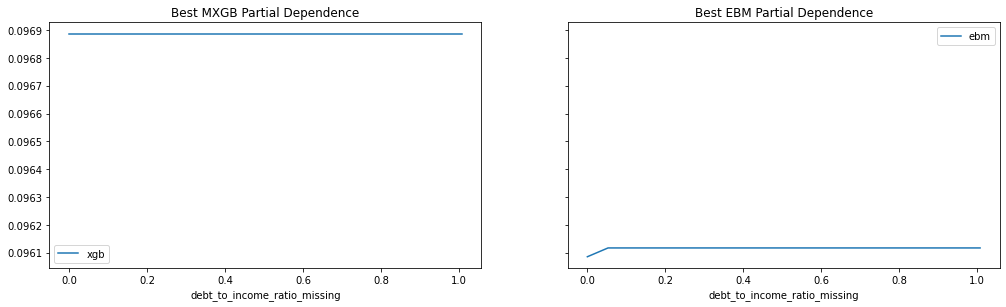

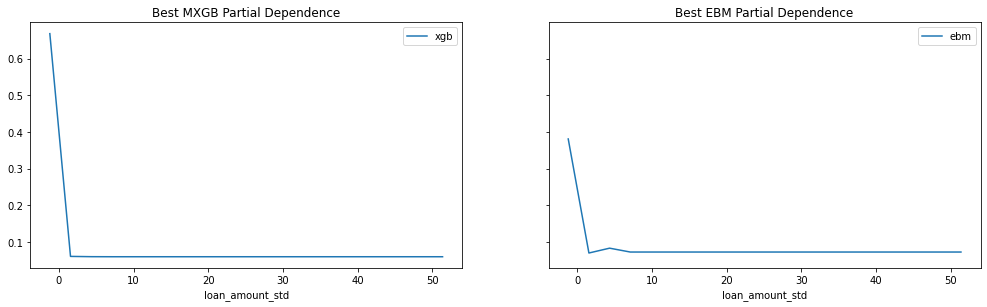

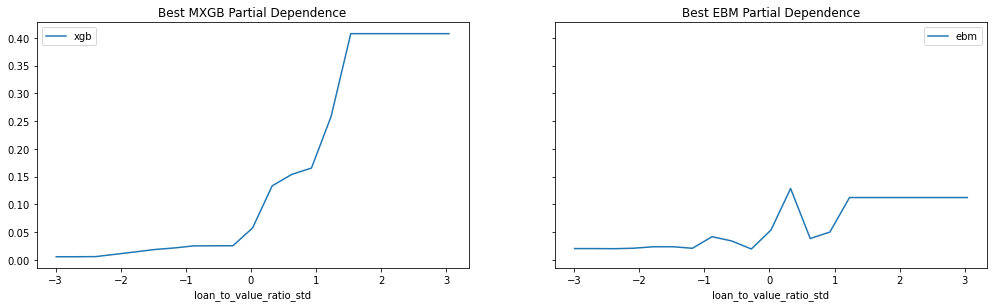

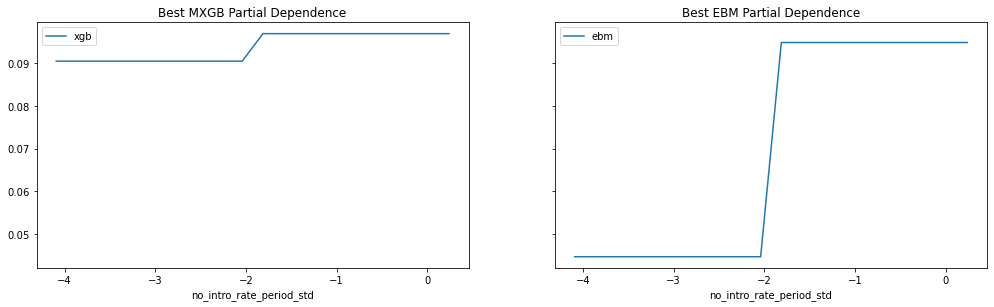

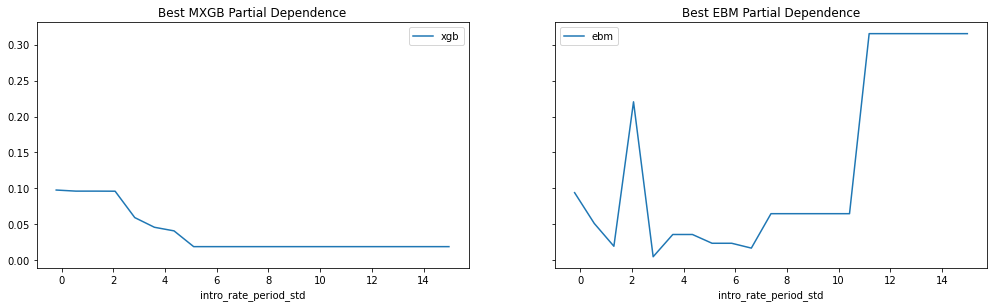

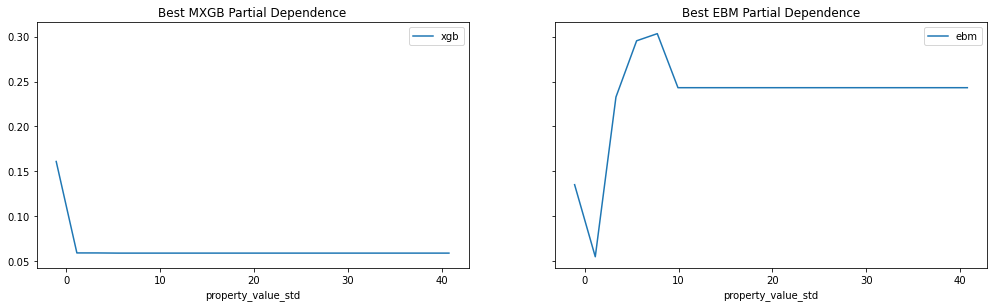

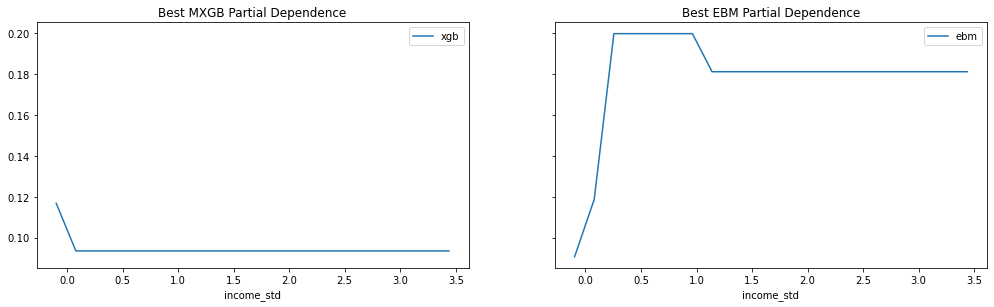

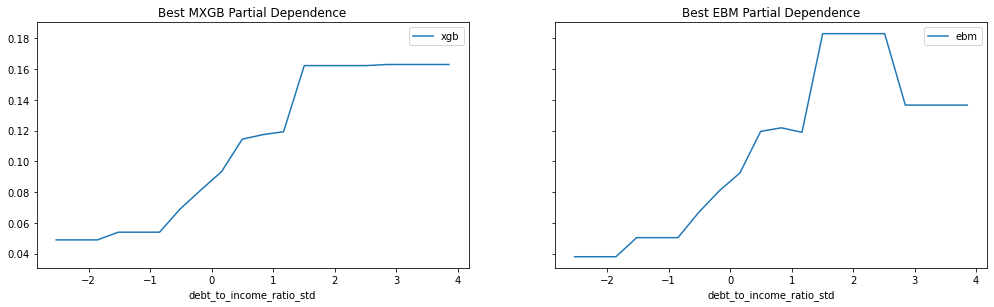

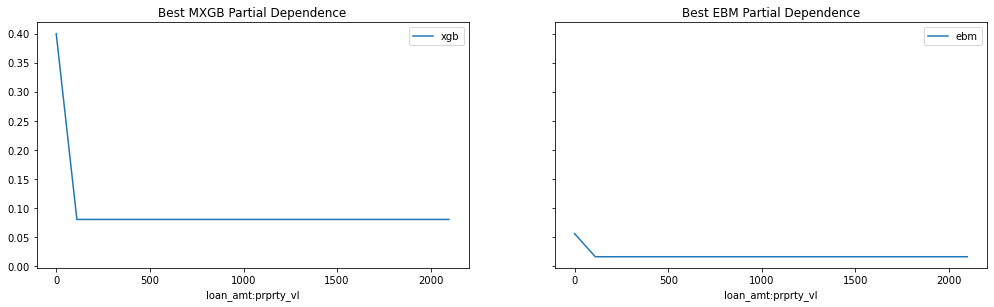

In [40]:
# loop through names to calculate par dep
for name in x_names:
   
    # init 2-pane plot
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2) # this may need to be changed
 
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax0, title='Best MXGB Partial Dependence')
    ax0.set_xlabel(name)
    
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax1, title='Best EBM Partial Dependence')
    ax1.set_xlabel(name)

## 4.2 ICE (local feature behavior)

### Utility function for ICE curve and histogram for the corresponding features
* this is the edited version of the function from the explain module in rmltk package

In [41]:
def plot_pd_ice(x_name, par_dep_frame, ax=None):

    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.

    :param x_name: Name of variable for which to plot ICE and partial dependence.
    :param par_dep_frame: Name of Pandas frame containing ICE and partial
                          dependence values (tightly coupled to frame schema).
    :param ax: Matplotlib axis object to use.
    """

    # for standalone plotting
    if ax is None:

        # initialize figure and axis
        fig, ax = plt.subplots()

        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='grey',
                           linewidth=3,
                           ax=ax)

    # for grouped subplots
    else:

        # plot ICE
        par_dep_frame.drop('partial_dependence', axis=1).plot(x=x_name,
                                                              colormap='gnuplot',
                                                              ax=ax)

        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE: ' + x_name,
                           x=x_name,
                           y='partial_dependence',
                           color='red',
                           linewidth=3,
                           ax=ax)


def hist_mean_pd_ice_plot(x_name, y_name, valid, pd_ice_dict):

    """ Plots diagnostic plot of histogram with mean line overlay
        side-by-side with partial dependence and ICE.

    :param x_name: Name of variable for which to plot ICE and partial dependence.
    :param y_name: Name of target variable.
    :param valid: Pandas validation frame.
    :param pd_ice_dict: Dict of Pandas DataFrames containing partial dependence
                        and ICE values.
    """

    # initialize figure and axis
    fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=1.8, wspace=0.18)

    # if variable is *not* high cardinality
    # create histogram directly
    if valid[x_name].nunique() <= 20:
        mean_df = valid[[x_name, y_name]].groupby(by=x_name).mean()
        freq, bins, _ = ax.hist(valid[x_name], color='k')
        
    # if variable is high cardinality
    # bin, then create hist
    else:
        temp_df = pd.concat([pd.cut(valid[x_name], pd_ice_dict[x_name][x_name], duplicates='drop'),
                             valid[y_name]], axis=1)
        mean_df = temp_df.groupby(by=x_name).mean()
        del temp_df
        freq, bins, _ = ax.hist(valid[x_name], bins= pd_ice_dict[x_name][x_name], color='k')
        bins = bins[:-1]
        ## switch the range index to the bins and keep the values in the y_name column 
        mean_df[x_name] = bins
        mean_df.set_index([x_name], inplace=True)

    # annotate hist
    ax.set_xlabel(x_name)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Mean ' + y_name + ' Overlay')

    # create a new twin axis
    # on which to plot a line showing mean value
    # across hist bins
    ax1 = ax.twinx()
    _ = ax1.set_ylim((0, 1))
    _ = ax1.plot(bins, mean_df.reindex(labels=bins, fill_value=0)[y_name], color='r') ## add "fill_value = 0" to reindex() to convert NaN to 0
                                                                                      ## it draws the line for the values not matched to the length of bins
    _ = ax1.set_ylabel('Mean ' + y_name)
    _ = ax1.legend(['Mean ' + y_name], loc=1)

    # plot PD and ICE
    plot_pd_ice(x_name,
                pd_ice_dict[x_name],
                ax2)
    _ = ax2.legend(bbox_to_anchor=(1.05, 0),
                   loc=3,
                   borderaxespad=0.)

### Calculate PD for MXGB & EBM respectively

In [42]:
# create a dictionary to hold the computed PD for each feature
pd_dict_xgb = {}
pd_dict_ebm = {}
# cycle through names and model types to calculate par dep
for name in x_names:
   
    print('Calculating partial dependence for %s ...' % name)
   
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    # calculate par dep for xgb
    pd_dict_xgb[name] = par_dep(name, valid[x_names], best_mxgb, 'xgb')
    pd_dict_ebm[name] = par_dep(name, valid[x_names], best_ebm, 'ebm')
print("done")

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for loan_amt:prprty_vl ...
done


### Compute ICE for MXGB model

* percentiles are already calculated above while calculating the local feature importance (3.2)

In [43]:
mxgb_pd_ice_dict = copy.deepcopy(pd_dict_xgb)

# loop through selected features
for xs in x_names: 

    # collect bins used in partial dependence
    bins = list(mxgb_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(best_mxgb_percentiles.keys()):
        col_name = 'Percentile_' + str(i)
        mxgb_pd_ice_dict[xs][col_name] = par_dep(xs, valid[valid['row_id'] == int(best_mxgb_percentiles[i])][x_names],
                                                 best_mxgb, 'xgb', 
                                                 bins=bins)['partial_dependence']

### Plot ICE curve with histogram for each feature [MXGB]

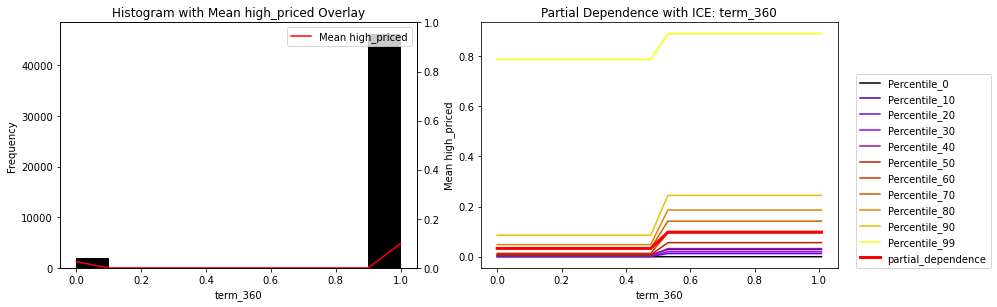

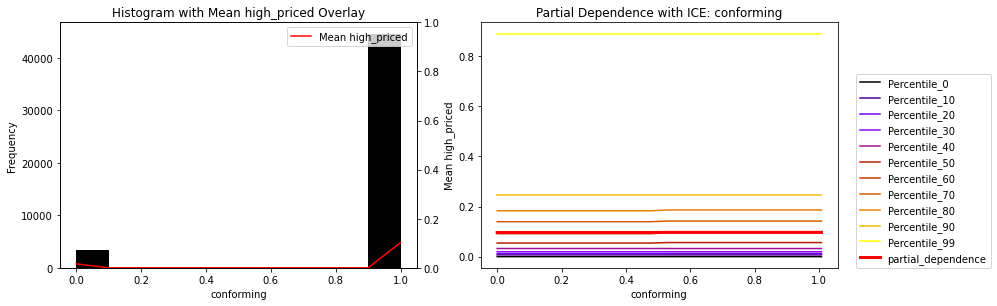

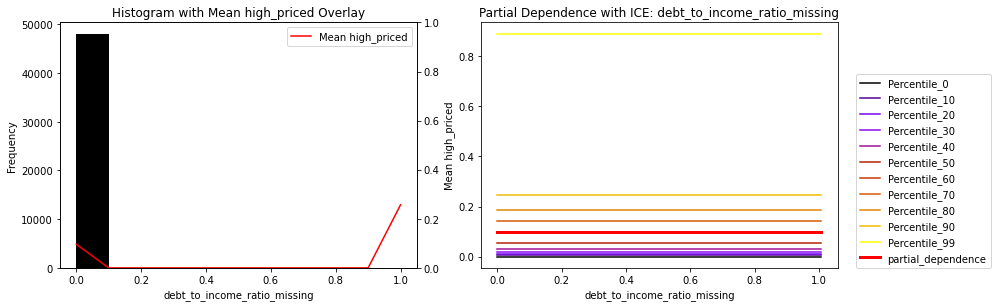

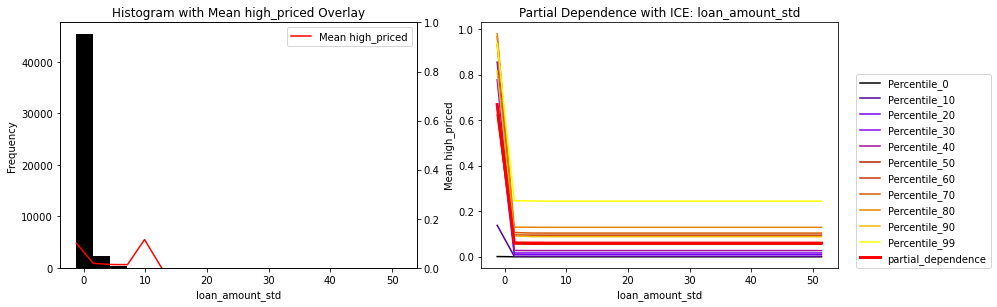

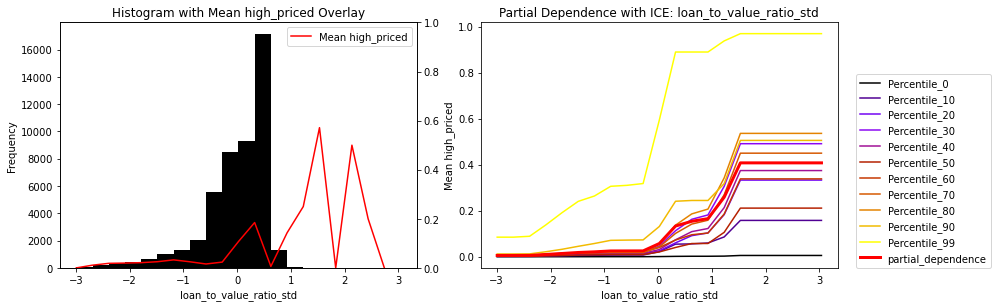

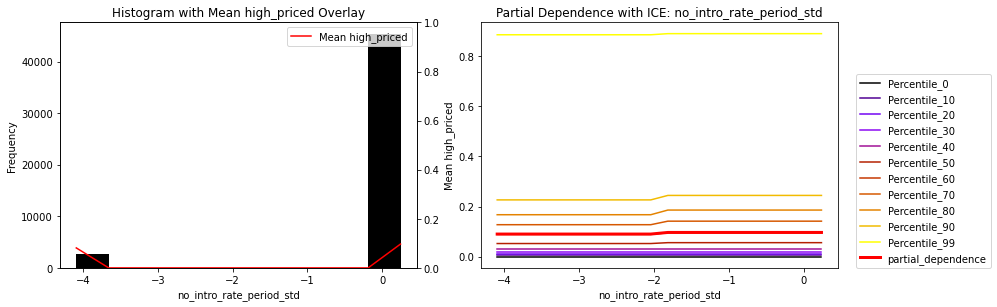

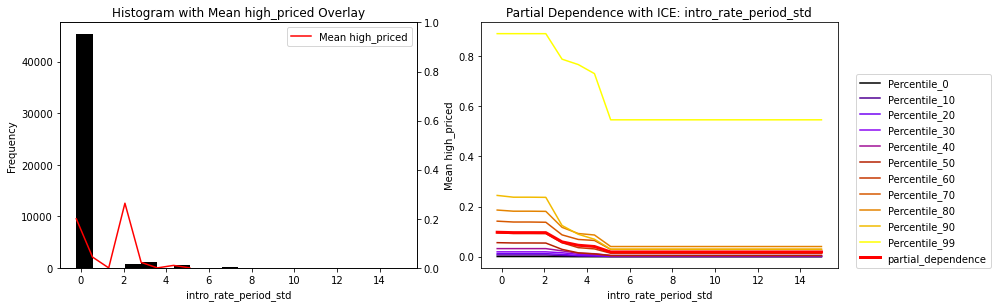

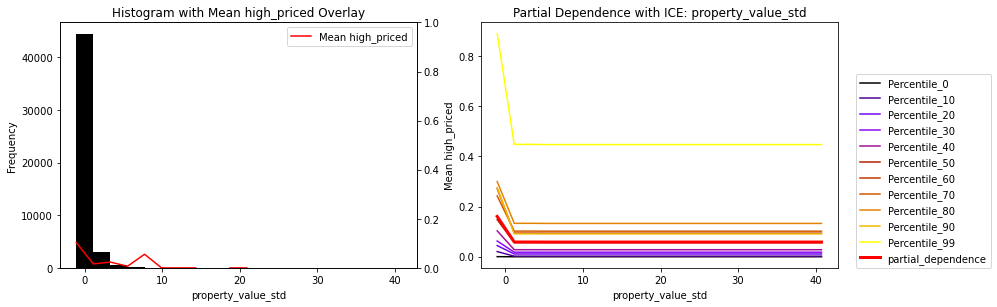

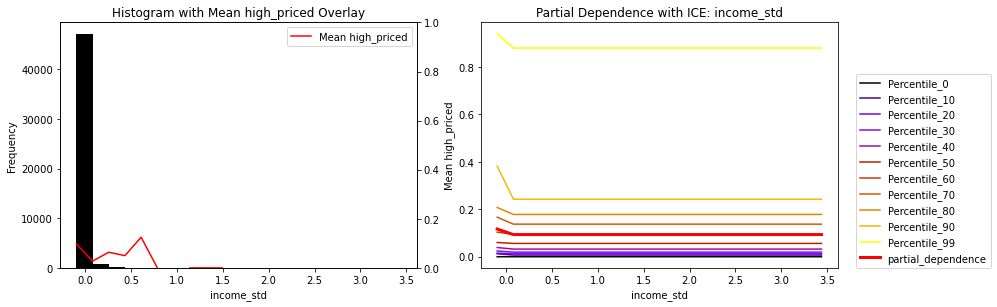

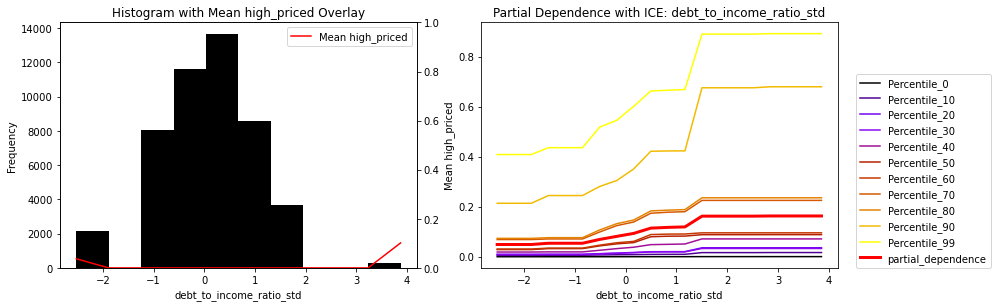

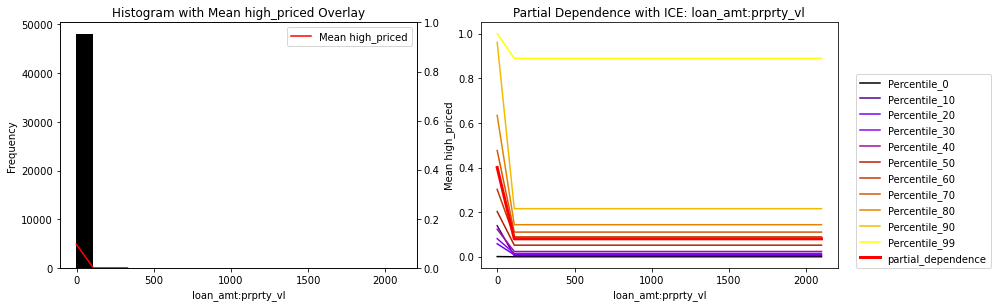

In [44]:
for xs in x_names: 
    hist_mean_pd_ice_plot(xs, y_name, valid, mxgb_pd_ice_dict)

* In the MXGB model, the values of every percentile demonstrate highly similar patterns to the partial dependence across all the features

### Compute ICE for EBM model

In [45]:
ebm_pd_ice_dict = copy.deepcopy(pd_dict_ebm)

# loop through selected features
for xs in x_names: 

    # collect bins used in partial dependence
    bins = list(ebm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(best_ebm_percentiles.keys()):
        col_name = 'Percentile_' + str(i)
        ebm_pd_ice_dict[xs][col_name] = par_dep(xs, valid[valid['row_id'] == int(best_ebm_percentiles[i])][x_names],
                                                 best_ebm, 'ebm', 
                                                 bins=bins)['partial_dependence']

### Plot ICE curve with histogram for each feature [EBM]

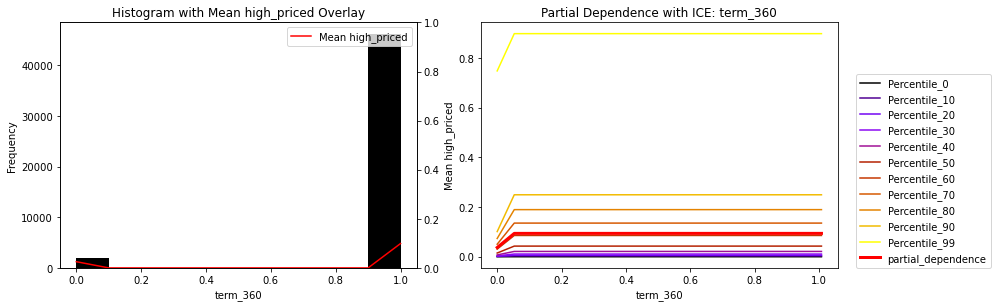

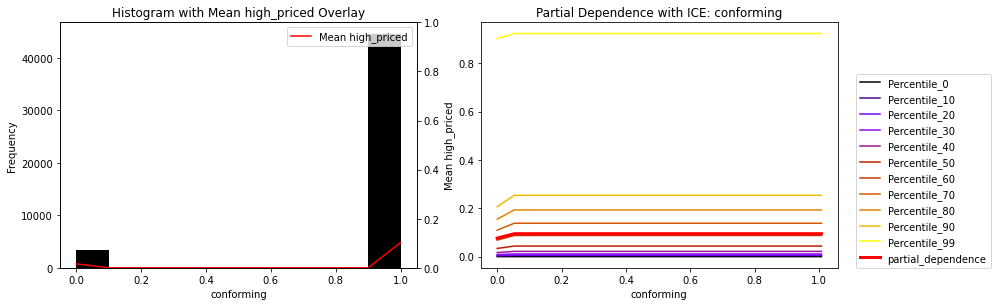

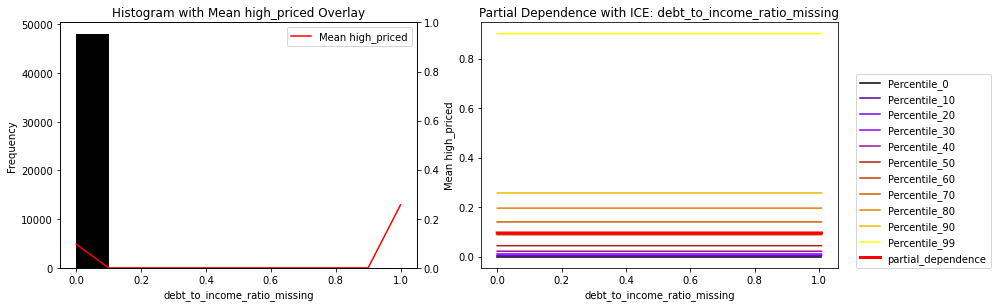

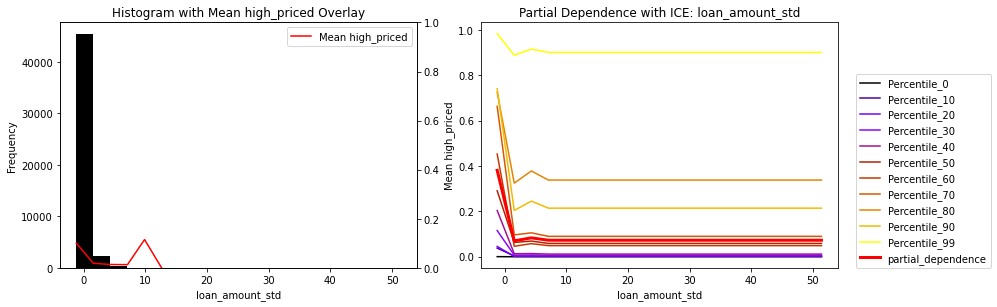

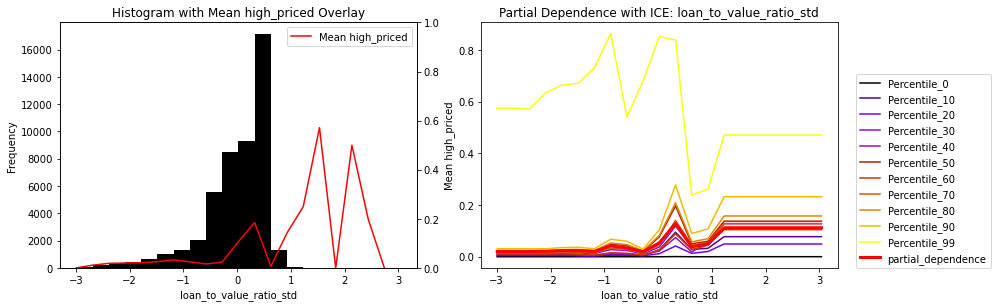

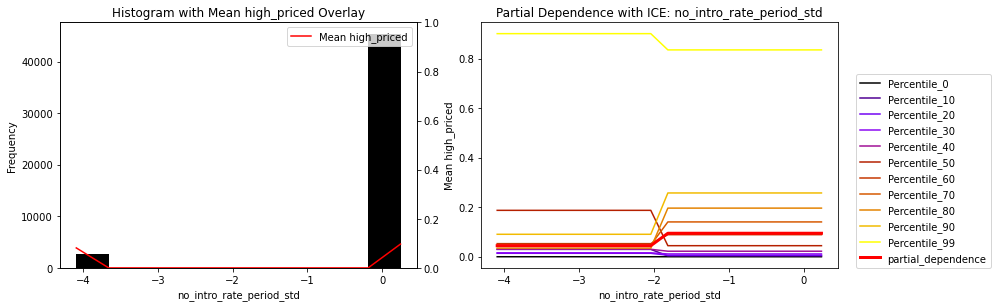

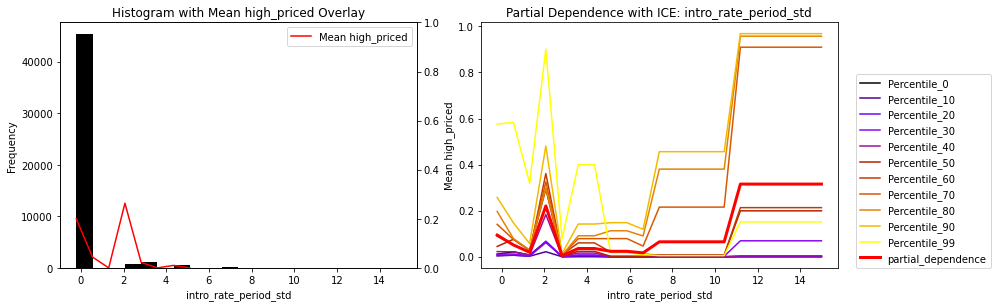

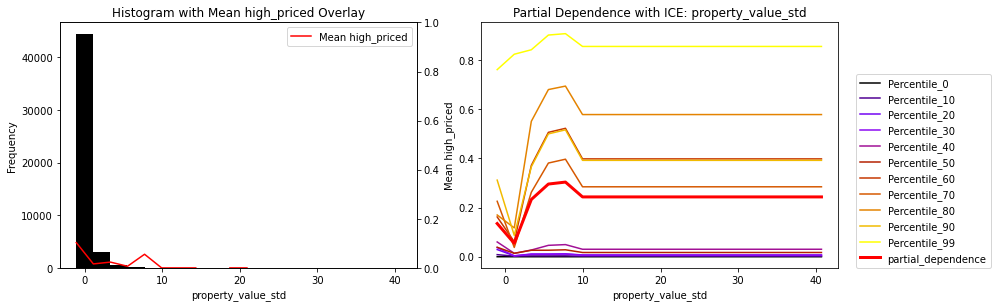

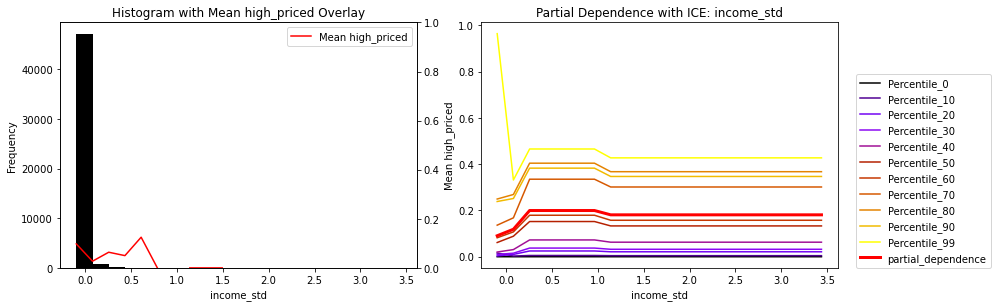

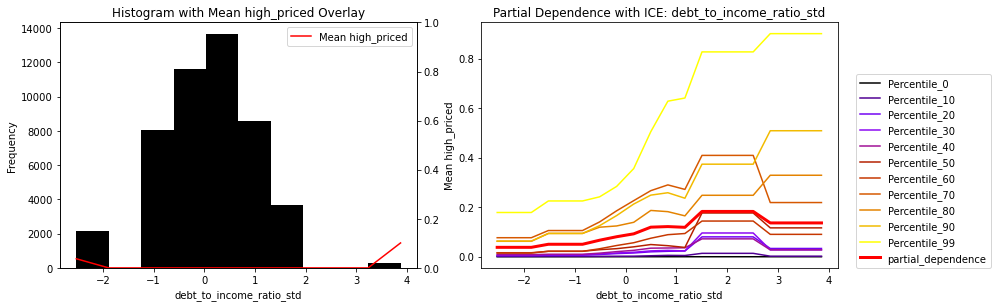

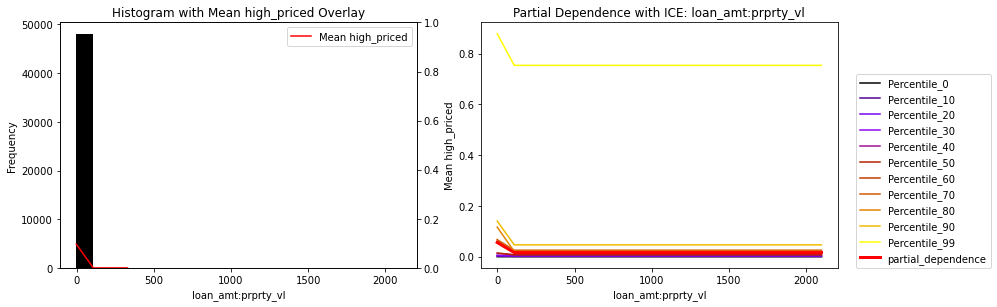

In [46]:
for xs in x_names: 
    hist_mean_pd_ice_plot(xs, y_name, valid, ebm_pd_ice_dict)

* In the EBM model, "loan_to_value_ratio_std", "no_intro_rate_period_std", and "intro_rate_period_std" features show that the values belonging to the highest percentile has distinct patterns from the partial dependence

# ------------------------------------------------------------------

# 5. Diagnose and Fix bias in EBM model (Mitigating Discrimination in ML)

## Utility functions

### Calculate confusion matrices by demographic group

In [75]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

### Calculate AIR

In [76]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))

### Select probability cutoff by F1

In [77]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame

### Random grid search

In [78]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air(). 

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """
    
    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name]) 

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del row_dict
        del ebm
            
    return best_ebm, ebm_grid_frame

## 5.1 Investigate Best Model (EBM) for Discrimination


### Find optimal cutoff based on F1

In [51]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.175858  0.096406
1    0.01  0.234172  0.374880
2    0.02  0.265226  0.477491
3    0.03  0.283574  0.530130
4    0.04  0.300024  0.571045
..    ...       ...       ...
96   0.96  0.000000  0.903594
97   0.97  0.000000  0.903594
98   0.98  0.000000  0.903594
99   0.99  0.000000  0.903594
100  1.00  0.000000  0.903594

[101 rows x 3 columns]

Best EBM F1: 0.3751 achieved at cutoff: 0.16 with accuracy: 0.7736.


### Find confusion matrices for demographic groups

In [52]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       562      1070
predicted: 0       168      1490

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1       108       268
predicted: 0        42      2821

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2195      6941
predicted: 0       953     24302

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1166      3592
predicted: 0       509     10573

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       954      2441
predicted: 0       303      6376



### Find AIR for Asian people 
* protect accepted: Asian people
* reference accepted: White People

In [53]:
print('Adverse impact ratio(AIR) for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.734
Asian proportion accepted: 0.884
Adverse impact ratio(AIR) for Asian people vs. White people: 1.204


### Find AIR for Black people
* protect accepted: Black people
* reference accepted: White People

In [54]:
print('Adverse impact ratio(AIR) for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.734
Black proportion accepted: 0.504
Adverse impact ratio(AIR) for Black people vs. White people: 0.686


### Find AIR for Female people
* protect accepted: female people
* reference accepted: male People

In [55]:
print('Adverse impact ratio(AIR) for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.700
Female proportion accepted: 0.663
Adverse impact ratio(AIR) for Females vs. Males: 0.948


* AIR for Asian & Female groups greater than 0.8 are acceptable
* AIR for Black people group is smaller than threshold 0.8 which should be improved by remediation

## 5.2 Remediation of discovered discrimination


## 5.2.1 Find cutoff with better Black vs. White AIR

In [56]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
22,0.22,0.360350,0.835672,0.802119
23,0.23,0.351112,0.844459,0.821155
24,0.24,0.342948,0.853434,0.839670
25,0.25,0.331011,0.862054,0.863095
26,0.26,0.316366,0.867447,0.875829


* Cutoffs in the 0.22-0.26 range provide increased accuracy and less bias towards Black people.

### Check that other groups are not adversely impacted by change

In [57]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.112
Adverse impact ratio for Black people vs. White people: 0.802
Adverse impact ratio for Females vs. Males: 0.972


* The new cutoff does not adversely affect other protected groups.

## 5.2.2 Model selection via quality and fairness


In [338]:
# start local timer
ebm2_tic = time.time()
SEED = 12345

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=100, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/100: 0.8286.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 

Grid search run 50/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 51/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 52/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 53/100:
T

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
EBM training completed in 3525.05 s.


### Display grid search results as table


In [339]:
ebm_grid_frame


,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[loan_to_value_ratio_std, conforming, no_intro_rate_period_std, lo...",0.828613,0.701511,100.0,4.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,"[income_std, loan_to_value_ratio_std, property_value_std, intro_ra...",0.803057,0.696179,100.0,4.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[intro_rate_period_std, debt_to_income_ratio_missing]",0.532000,1.007807,100.0,4.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[loan_amount_std, debt_to_income_ratio_missing, loan_to_value_rati...",0.805834,0.675765,100.0,4.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[debt_to_income_ratio_std, term_360, loan_amt:prprty_vl, property_...",0.807590,0.736124,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,128,64,5,4,4,0.010,0.50,1,3,"[no_intro_rate_period_std, intro_rate_period_std, loan_amt:prprty_...",0.806016,0.760432,100.0,4.0,12345.0
96,512,16,15,12,4,0.010,0.10,5,5,"[income_std, intro_rate_period_std, debt_to_income_ratio_missing, ...",0.706026,0.902089,100.0,4.0,12345.0
97,128,32,5,12,4,0.050,0.50,2,5,"[term_360, property_value_std, no_intro_rate_period_std, conformin...",0.820302,0.687095,100.0,4.0,12345.0
98,256,64,15,8,4,0.001,0.25,5,5,"[no_intro_rate_period_std, loan_amt:prprty_vl, income_std]",0.704568,0.971157,100.0,4.0,12345.0


### Display grid search results as plot

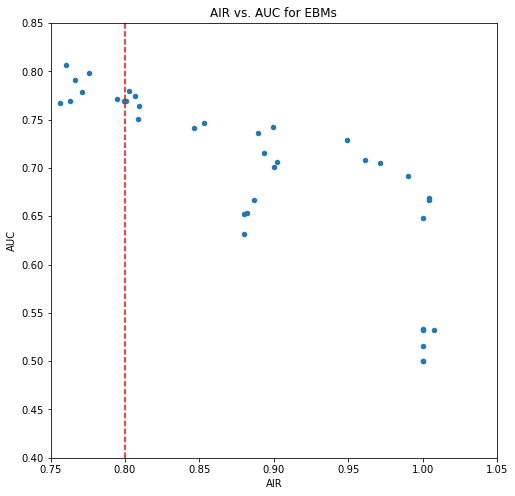

In [340]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

### Retrain most accurate model above 0.8 AIR

In [341]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7797 above 0.8 AIR (0.8025).
Remediated EBM retrained with AUC: 0.7797.


### Check that other groups are not adversely impacted by change

In [343]:

# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.132
Adverse impact ratio for Black people vs. White people: 0.802
Adverse impact ratio for Females vs. Males: 0.953


## 5.2.3 Preprocessing approach: AIF360 - Disparate Impact Remover

### data preprocessing


In [65]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [165]:
train_df = tr_df.copy(deep = True)
# Drop row_id
train_df = train_df.drop(['row_id'], axis = 1)

In [166]:
df = train_df.dropna()
df.isna().sum()

black                           0
asian                           0
white                           0
amind                           0
hipac                           0
hispanic                        0
non_hispanic                    0
male                            0
female                          0
agegte62                        0
agelt62                         0
term_360                        0
conforming                      0
debt_to_income_ratio_missing    0
loan_amount_std                 0
loan_to_value_ratio_std         0
no_intro_rate_period_std        0
intro_rate_period_std           0
property_value_std              0
income_std                      0
debt_to_income_ratio_std        0
high_priced                     0
loan_amt:prprty_vl              0
dtype: int64

In [167]:
df.drop(df[(df["black"] == 0) & (df["white"] == 0)].index, inplace=True)

In [168]:
# convert the pandas dataframe to the data format required by aif360
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df[["black"] + x_names + [y_name]],
    label_names=['high_priced'],
    protected_attribute_names=['black'])

### Fix the dataset through Disparate Impact Remover for debiasing

In [169]:
# create a DisparateImpactRemover object, 
# which is used to run a repairer on the non-protected features of the dataset. 
# After running the repairer, 
# convert the BinaryLabelDataset that was produced by running the DisparateImpactRemover 
# back into a Pandas dataframe

di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed = dataset_transf_train.convert_to_dataframe()[0]

### Split the original training data set into train & valid sets 

In [170]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.7 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(transformed)) < ratio # define indices of 70% corresponding to the training set

trans_train = transformed[split]
trans_valid = transformed[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (trans_train.shape[0], trans_train.shape[1]))
print('Validation data rows = %d, columns = %d' % (trans_valid.shape[0], trans_valid.shape[1]))

Train data rows = 6792, columns = 13
Validation data rows = 3002, columns = 13


### Train a EBM model on the repaired train set

In [73]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm_deb = ebm_grid(trans_train, trans_valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.7956.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

### Merge the train set with the predictions calculated on the valid set


In [74]:
ebm_deb_phat = pd.DataFrame(best_ebm_deb.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
ebm_deb_phat = pd.concat([valid.reset_index(drop=True), ebm_deb_phat], axis=1)

### Try another random grid search incorporating AIR in addition to AUC with the cutoff 0.17

In [79]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm4, ebm_grid_frame3 = ebm_grid(trans_train, ebm_deb_phat, x_names, y_name, gs_params=gs_params, n_models=100, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/100: 0.7382.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 51/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 52/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 53/100:
Training with parameters:

Grid search run 100/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
EBM training completed in 338.94 s.


### Retrain most accurate model above 0.8 AIR

In [107]:
# extract new params dict from ebm_grid_frame
best_rem_params = ebm_grid_frame3.loc[ebm_grid_frame3['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
best_rem_x_names = best_rem_params['features']
del best_rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (best_rem_params['auc'], best_rem_params['air']))
del best_rem_params['auc']
del best_rem_params['air']

# reset some parameters to integers
best_rem_params['random_state'] = int(best_rem_params['random_state'])
best_rem_params['n_jobs'] = int(best_rem_params['n_jobs'])

# retrain
best_rem_ebm = ExplainableBoostingClassifier(**best_rem_params)
best_rem_ebm.fit(trans_train[best_rem_x_names], trans_train[y_name]) 
best_rem_ebm_perf = ROC(best_rem_ebm.predict_proba).explain_perf(valid[best_rem_x_names], valid[y_name])
best_rem_auc = best_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % best_rem_auc)

Best AUC: 0.7807 above 0.8 AIR (0.8489).
Remediated EBM retrained with AUC: 0.7807.


### Merge the train set with the predictions newly computed on the valid set


In [108]:
best_rem_ebm_phat = pd.DataFrame(best_rem_ebm.predict_proba(valid[best_rem_x_names])[:, 1], columns=['phat']) 
best_rem_ebm_phat = pd.concat([valid.reset_index(drop=True), best_rem_ebm_phat], axis=1)

### ROC curve & AUC

In [417]:
valid_roc =  valid.copy(deep=True)
valid_roc = valid_roc.reset_index(drop = True)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


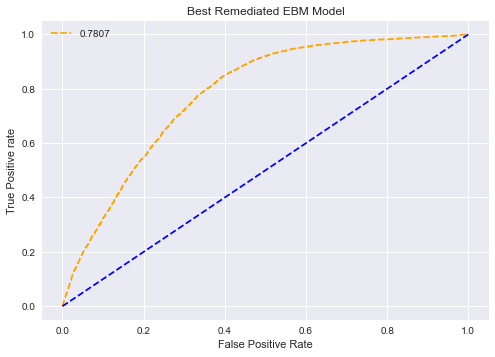

In [429]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
plt.style.use("seaborn")

# ROC curve for the best remediated model 
fpr, tpr, thresh = roc_curve(valid_roc[y_name], best_rem_ebm_phat.loc[:, "phat"], pos_label=1)

# ROC for tpr = fpr
random_probs = [0 for i in range(len(valid_roc[y_name]))]
p_fpr, p_tpr, _=roc_curve(valid_roc[y_name], random_probs, pos_label=1)

# auc scores
auc_score = roc_auc_score(valid_roc[y_name], best_rem_ebm_phat.loc[:, "phat"])

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label=np.round(auc_score,4))
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Best Remediated EBM Model')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc = "best")
plt.savefig('ROC',dpi=300)
plt.show();

### calculate confusion matrix

In [109]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
best_cm_dict = {}

for name in demographic_group_names:
    best_cm_dict[name] = get_confusion_matrix(best_rem_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.17)
    print(best_cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       290       509
predicted: 0       440      2051

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        26       137
predicted: 0       124      2952

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1       905      2813
predicted: 0      2243     28430

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       474      1499
predicted: 0      1201     12666

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       432       987
predicted: 0       825      7830



### calculate AIR for the all the three groups 

In [110]:
# calculate new confusion matrics for each group
best_rem_cm_dict = {}
for name in demographic_group_names:
    best_rem_cm_dict[name] = get_confusion_matrix(best_rem_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(best_rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(best_rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(best_rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.065
Adverse impact ratio for Black people vs. White people: 0.849
Adverse impact ratio for Females vs. Males: 0.981


* RESULT: the new ebm model built based on the data set repaired by AIF360-DisparateImpactRemover improved the AIR between the black people and white people [0.686 -> 0.849] keeping the other groups still being acceptable.
***
* Asian vs. White: 1.204 -> 1.065
* Black vs. White: 0.686 -> 0.849
* Females vs. Males: 0.948 -> 0.981
***

# ------------------------------------------------------

# 6. ML Security

### Utility function that trains a cross-validated decision tree



In [320]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree

### Utility function that converts h2o MOJO into graphviz file

In [321]:
def get_gv(title, model_id, mojo_path):
    
    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.
        
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

### Utility function that converts graphviz file into PNG


In [322]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    # construct call to generate PNG from
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)
    _ = subprocess.call(png_args)

### Fit interpretable model (EBM)

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [323]:
best_rem_params

{'max_bins': 128,
 'max_interaction_bins': 16,
 'interactions': 15,
 'outer_bags': 4,
 'inner_bags': 4,
 'learning_rate': 0.05,
 'validation_size': 0.25,
 'min_samples_leaf': 5,
 'max_leaves': 5,
 'early_stopping_rounds': 100.0,
 'n_jobs': 4,
 'random_state': 12345}

In [324]:
best_rem_x_names

['no_intro_rate_period_std',
 'debt_to_income_ratio_std',
 'income_std',
 'loan_to_value_ratio_std',
 'property_value_std',
 'intro_rate_period_std']

In [325]:
# params dict for remediated models are found above (5.2.2)
# x variables
rem_x_names = ['no_intro_rate_period_std',
               'income_std',
               'property_value_std',
               'debt_to_income_ratio_std',
               'loan_to_value_ratio_std',
               'intro_rate_period_std']

# retrain
rem_ebm = ExplainableBoostingClassifier(**best_rem_params)
rem_ebm.fit(trans_train[rem_x_names], trans_train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7807.


## 6.1 White-hat surrogate model


In [326]:
# best guess at feature distributions
schema_dict = {'loan_to_value_ratio_std':      {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'}, 
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},  
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
        
    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)
        
# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

### Visualize simulated data

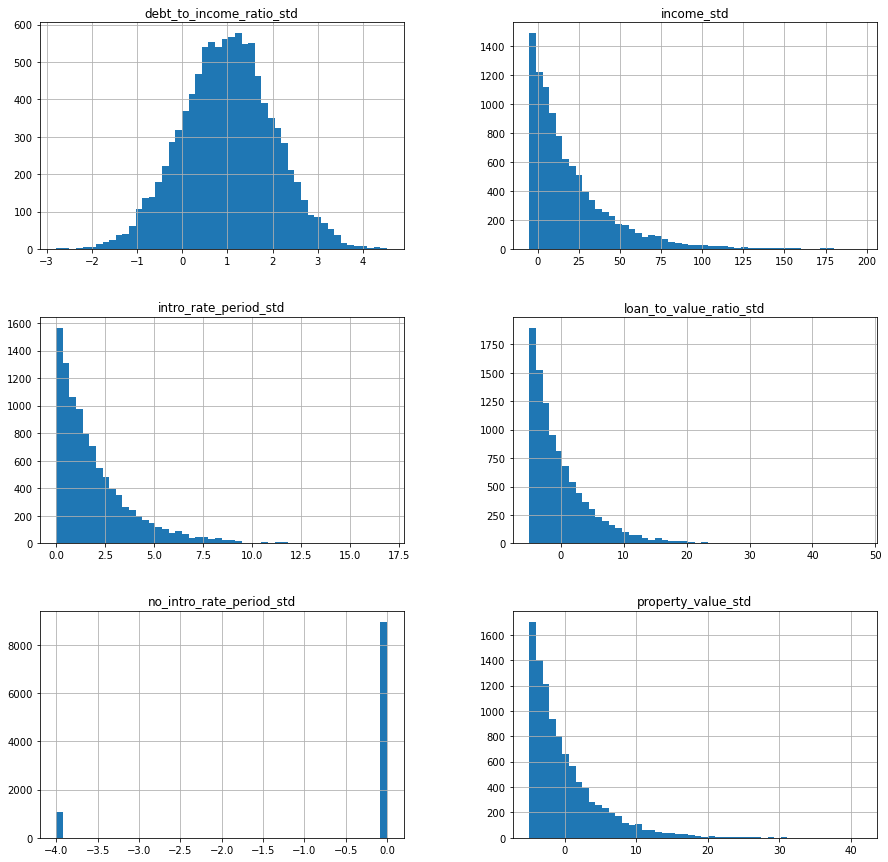

In [327]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

### First call to blackbox model for predictions on random data

In [328]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat']) 
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,income_std,intro_rate_period_std,debt_to_income_ratio_std,phat
0,8.268953,0,-4.881351,27.121767,2.018107,1.124646,0.222780
1,-3.098267,0,14.885449,131.200745,1.029955,1.123252,0.157327
2,-3.983793,0,4.406956,7.535382,2.853882,2.683992,0.070407
3,-3.855699,0,-4.749644,27.280999,0.248822,-0.851652,0.074320
4,-0.806533,0,-4.860455,-3.846006,1.796115,0.344748,0.086012


### Extract a stolen decision tree model

In [117]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt', 
                      SEED, 
                      'Stolen Model')

Generated MOJO path:
 /Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset/stolen_dt.zip
Discovered H2O jar path:
 /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /opt/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/alex/Desktop/Master/Responsible_ML_DNSC6209_11/dataset/stolen_dt.zip -o stolen_dt.gv --title Stolen Model
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


### View stolen model


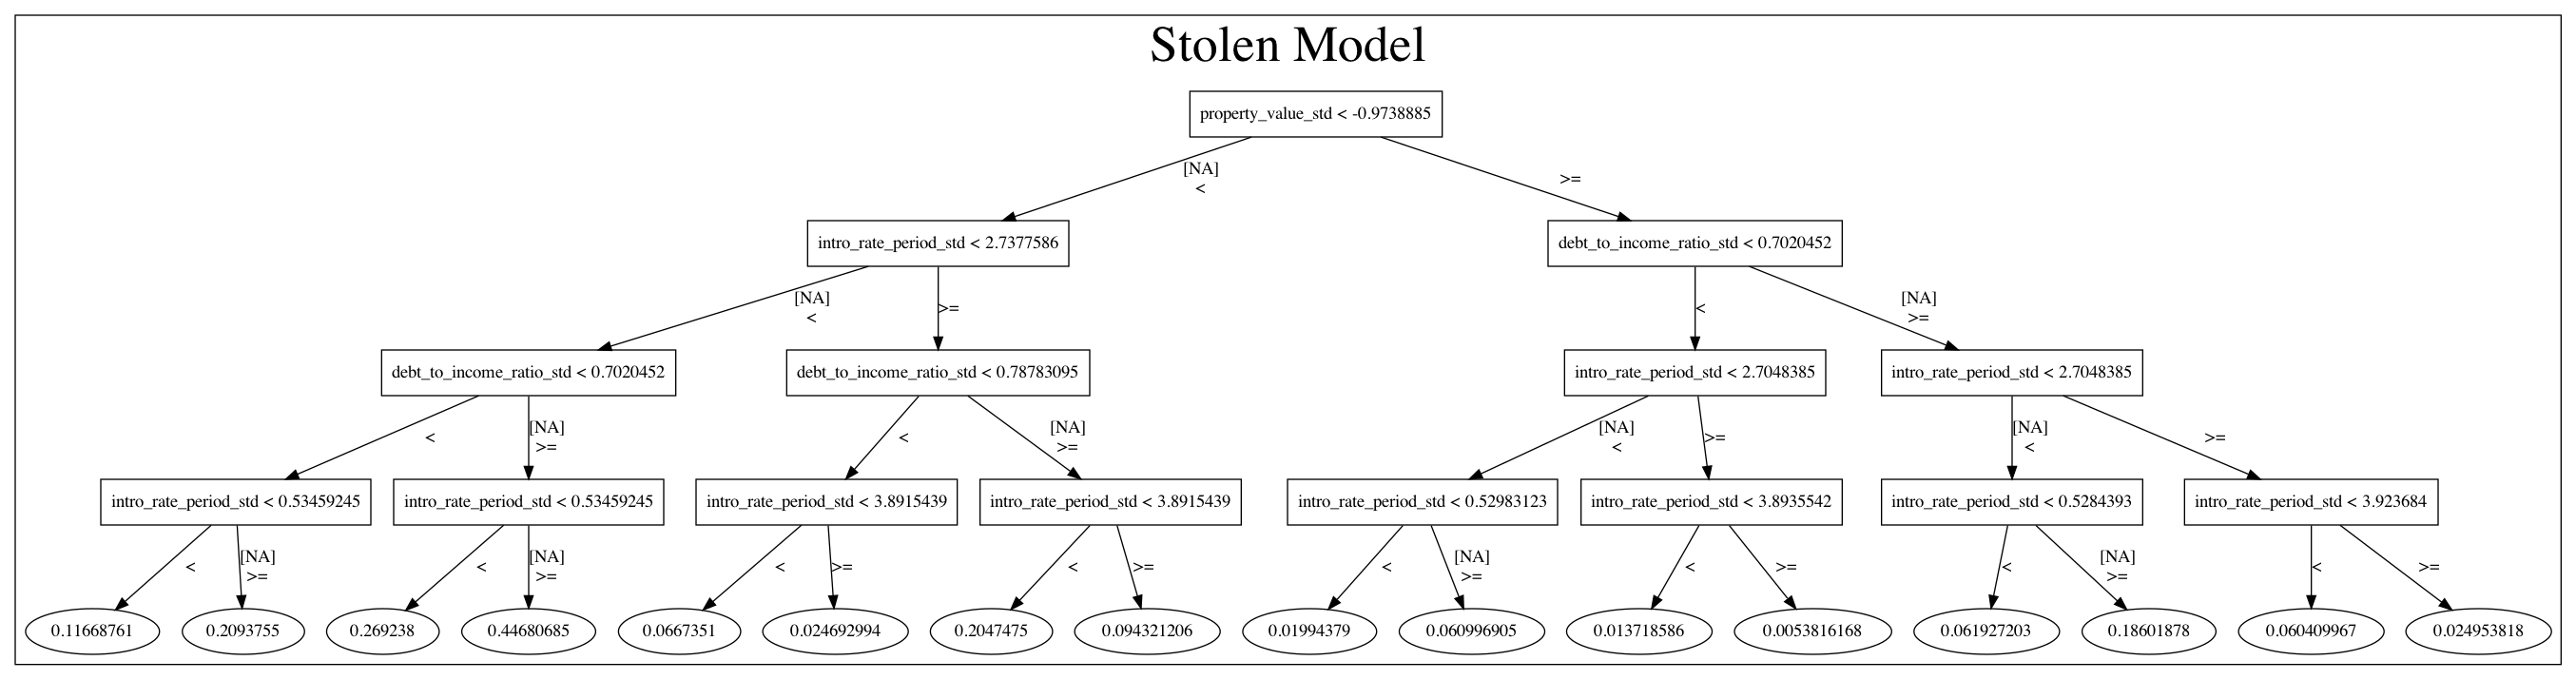

In [118]:
display(Image(('stolen_dt.png')))

Now an attacker has a basic flow chart for how the EBM works. This can be used as a sandbox for subsequent attacks!


### Variable importance for stolen model


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


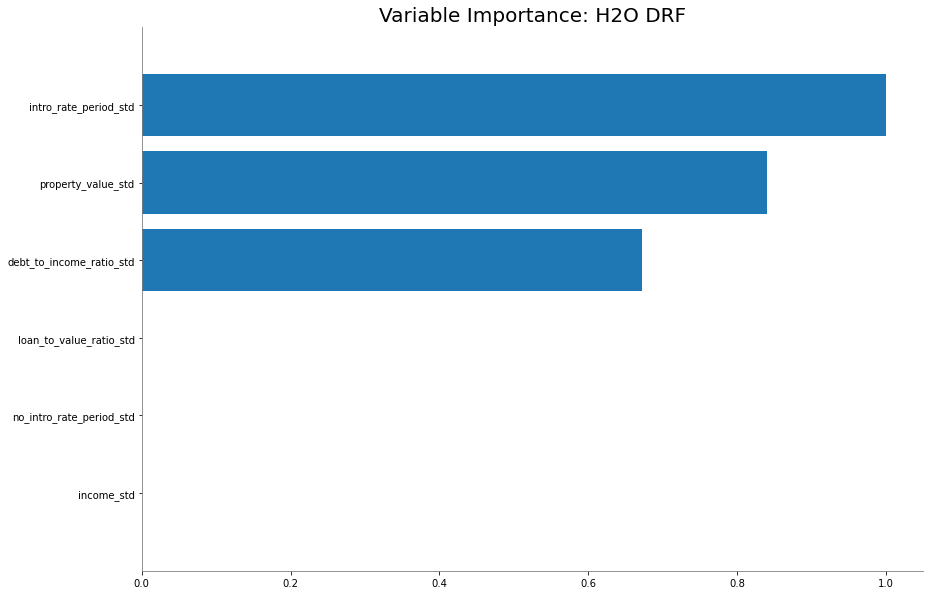

In [119]:
stolen_dt.varimp_plot()

### Assess accuracy of stolen model

In [120]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.06256367,0.0010884019,0.06379647,0.062158894,0.06173566
1,mean_residual_deviance,0.008638854,3.0330618E-4,0.0089604,0.008357869,0.008598293
2,mse,0.008638854,3.0330618E-4,0.0089604,0.008357869,0.008598293
3,r2,0.701333,0.0051608477,0.6956236,0.70566636,0.70270896
4,residual_deviance,0.008638854,3.0330618E-4,0.0089604,0.008357869,0.008598293
5,rmse,0.09293592,0.0016290826,0.09465939,0.09142139,0.09272698
6,rmsle,0.07129835,0.0011658267,0.072524466,0.07020401,0.07116658


* The stolen model is accurate enough (R2=0.7, RMSE=0.09), and importantly, very stable.

## 6.2 Use Stolen Model to Craft Adversarial Examples


In [121]:
random_frame.head()

,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,income_std,intro_rate_period_std,debt_to_income_ratio_std
0,8.268953,0,-4.881351,27.121767,2.018107,1.124646
1,-3.098267,0,14.885449,131.200745,1.029955,1.123252
2,-3.983793,0,4.406956,7.535382,2.853882,2.683992
3,-3.855699,0,-4.749644,27.280999,0.248822,-0.851652
4,-0.806533,0,-4.860455,-3.846006,1.796115,0.344748


### Use stolen model to find seed rows for adversary searches

In [122]:
low_adversary_seed = random_frame.loc[(random_frame['property_value_std'] >= -0.058) &
                                      (random_frame['debt_to_income_ratio_std'] < 1.308) & 
                                      (random_frame['intro_rate_period_std'] >= 2.375), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['property_value_std'] < -0.647) & 
                                       (random_frame['intro_rate_period_std'] < 2.28) & 
                                       (random_frame['debt_to_income_ratio_std'] >= 1.3), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
loan_to_value_ratio_std     -0.144487
no_intro_rate_period_std    -0.408537
property_value_std           4.858328
income_std                  19.476691
intro_rate_period_std        4.443254
debt_to_income_ratio_std     0.342944
dtype: float64

High adversarial example search seed row:
loan_to_value_ratio_std      0.221014
no_intro_rate_period_std    -0.405333
property_value_std          -3.102395
income_std                  20.533152
intro_rate_period_std        0.939042
debt_to_income_ratio_std     1.995517
dtype: float64


### Perturb seed row to find low scoring adversarial examples

In [329]:
rem_x_names

['no_intro_rate_period_std',
 'income_std',
 'property_value_std',
 'debt_to_income_ratio_std',
 'loan_to_value_ratio_std',
 'intro_rate_period_std']

In [124]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# quantiles over which to search 
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                low_adversary_seed['property_value_std'] = a
                low_adversary_seed['intro_rate_period_std'] = b
                low_adversary_seed['debt_to_income_ratio_std'] = c
                low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                    ignore_index=True, sort=False)
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,income_std,intro_rate_period_std,debt_to_income_ratio_std
0,-0.144487,-0.408537,17.713613,19.476691,9.06958,-1.340151
1,-0.144487,-0.408537,17.713613,19.476691,9.06958,-0.693286
2,-0.144487,-0.408537,17.713613,19.476691,9.06958,-0.293709
3,-0.144487,-0.408537,17.713613,19.476691,9.06958,0.329686
4,-0.144487,-0.408537,17.713613,19.476691,9.06958,1.009426


### Perturb seed row to find high scoring adversarial examples

In [125]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                high_adversary_seed['property_value_std'] = a
                high_adversary_seed['intro_rate_period_std'] = b
                high_adversary_seed['debt_to_income_ratio_std'] = c
                high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                    ignore_index=True, sort=False)
                    
# view potential high scoring adversarial examples
high_adversary_frame.head()

,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,income_std,intro_rate_period_std,debt_to_income_ratio_std
0,0.221014,-0.405333,-4.942814,20.533152,0.018175,3.341645
1,0.221014,-0.405333,-4.942814,20.533152,0.018175,2.643168
2,0.221014,-0.405333,-4.942814,20.533152,0.018175,2.297496
3,0.221014,-0.405333,-4.942814,20.533152,0.018175,1.671775
4,0.221014,-0.405333,-4.942814,20.533152,0.018175,1.009426


### Second call to blackbox API to test adversarial examples

In [126]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,loan_to_value_ratio_std,no_intro_rate_period_std,property_value_std,income_std,intro_rate_period_std,debt_to_income_ratio_std,phat
0,-0.144487,-0.408537,17.713613,19.476691,9.069580,-1.340151,0.004007
35,-0.144487,-0.408537,10.033423,19.476691,4.608000,-1.340151,0.004007
50,-0.144487,-0.408537,6.693448,19.476691,9.069580,-1.340151,0.004007
55,-0.144487,-0.408537,6.693448,19.476691,6.053382,-1.340151,0.004007
25,-0.144487,-0.408537,10.033423,19.476691,9.069580,-1.340151,0.004007
...,...,...,...,...,...,...,...
172,0.221014,-0.405333,-4.741907,20.533152,1.383623,2.297496,0.801647
171,0.221014,-0.405333,-4.741907,20.533152,1.383623,2.643168,0.801647
143,0.221014,-0.405333,-4.942814,20.533152,0.561665,1.671775,0.801647
216,0.221014,-0.405333,-3.567477,20.533152,0.561665,2.643168,0.801647


* We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API. These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan.

# -------------------------------------------------------

## 7. Model Debugging

## 7.1 Sensitivity Analysis: Stress Testing

### features used for the best remediated EBM (AIR > 0.8)

In [330]:
rem_x_names

['no_intro_rate_period_std',
 'income_std',
 'property_value_std',
 'debt_to_income_ratio_std',
 'loan_to_value_ratio_std',
 'intro_rate_period_std']

### Simulate recession conditions in validation data

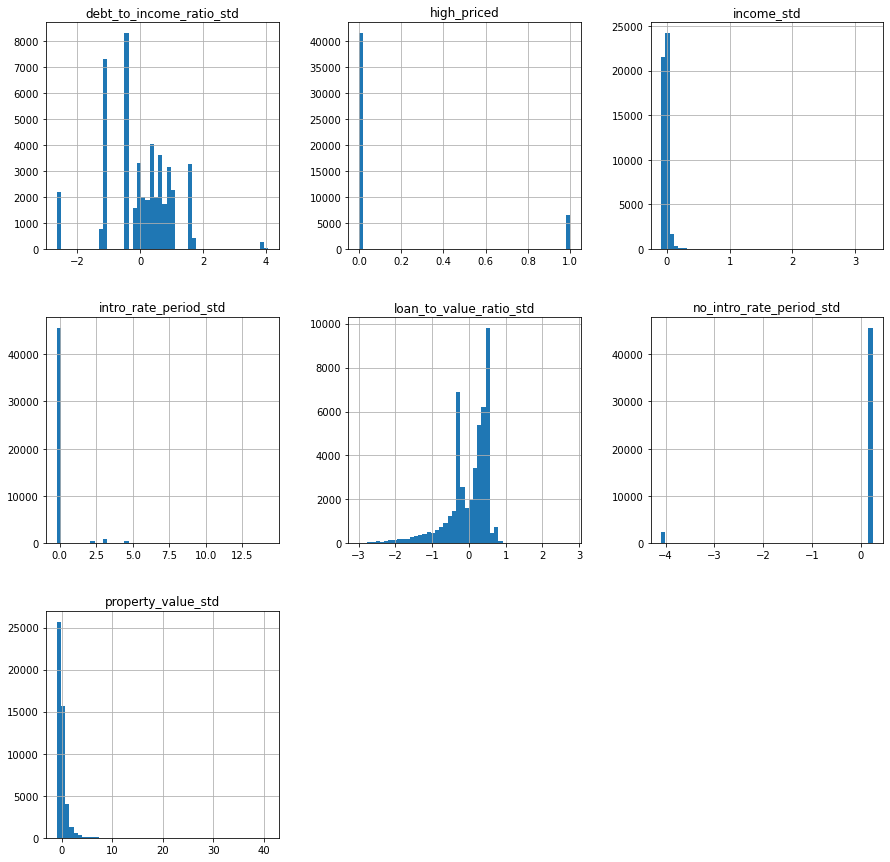

In [133]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = -0.215304

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# lower loan to value ratio by 5%
rec_valid.loc[affected, 'loan_to_value_ratio_std'] = rec_valid.loc[affected, 'loan_to_value_ratio_std'] * 0.95

# 5% higher debt-to-income ratios 
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

### Find AUC for best model in simulated recession conditions


In [134]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6886.


Remediated EBM retrained with AUC: 0.6886.
Note the major drop in performance for recession conditions, which is normal for all models and usually worse for complex ML models.

Also, this tells us we need to monitor this model carefully, because when recession conditions begin, this model will fail quickly.

## 7.2 Residual Analysis


### Calculate predictions and logloss residuals for all data

In [374]:
# shortcut names
yhat_name = 'phat'
r_name = 'r' 

# calculate predictions
rem_ebm_phat = pd.DataFrame(best_rem_ebm.predict_proba(transformed[best_rem_x_names])[:, 1], columns=['phat']) 
rem_ebm_phat = pd.concat([transformed.reset_index(drop=True), rem_ebm_phat], axis=1)

# calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])

### Plot residuals

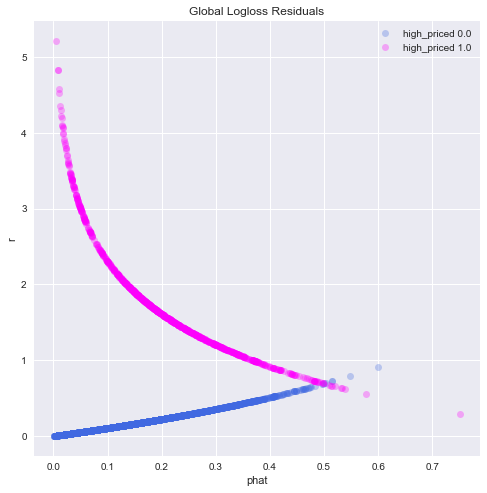

In [375]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = rem_ebm_phat.groupby(y_name) # define groups for levels of high_priced
for name, group in groups:
    ax_.plot(group.phat, group.r, 
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Residuals are very unbalanced. This model struggles to predict when customers will recieve a high-priced loan correctly. It does much better when predicting customers will NOT receive a high-priced loan. There are also some very noticiable outliers.

## 7.3 Remediation


## 7.3.1 Remediation: Remove Outliers

### Find outliers


In [392]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,black,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_amt:prprty_vl,high_priced,phat,r
4264,0.0,1.0,1.0,0.0,-0.998089,-1.163140,0.244394,-0.215304,-0.782611,-0.046544,-0.425131,0.176267,1.0,0.005438,5.214310
9595,0.0,1.0,1.0,0.0,-1.042062,-1.892723,0.244394,-0.215304,-0.751776,-0.041347,-1.156406,0.162800,1.0,0.008024,4.825320
6144,1.0,1.0,1.0,0.0,-0.954117,-1.846023,0.244394,-0.215304,-0.720941,-0.041347,-1.156406,0.687862,1.0,0.008056,4.821378
1139,0.0,1.0,1.0,0.0,-0.382476,-0.280590,-4.091747,3.163008,-0.443428,-0.025062,-1.156406,0.194092,1.0,0.010281,4.577422
4854,1.0,1.0,1.0,0.0,-0.910145,-2.647172,0.244394,-0.215304,-0.165915,-0.014668,-2.527547,0.151007,1.0,0.010856,4.523032


### Remove worst outliers


In [411]:
n_remove = 10
rem_data = transformed.copy(deep=True)  # using debiased dataset 
rem_data = rem_data.reset_index(drop=True)
rem_data.drop(list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

### Retrain remediated EBM on the repaired data

In [412]:
np.random.seed(SEED) # preserve exact reproducibility for this cell
split_ratio = 0.9 # assigning more proportion to the train part considering the shrinked data size 

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_ebm2 = ExplainableBoostingClassifier(**best_rem_params)
rem_ebm2.fit(rem_train[best_rem_x_names], rem_train[y_name]) 
rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[best_rem_x_names], rem_valid[y_name])
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated EBM AUC: %.4f.' % rem_auc2)

Remediated train data rows = 8767, columns = 13
Remediated validation data rows = 1017, columns = 13
Remediated EBM AUC: 0.7946.


* After droping part of the logloss residuals, the AUC computed on the rem_valid has increased 
* 0.7807 -> 0.7946

---

### AUC on the original valid set

In [413]:
from sklearn.metrics import roc_curve
# calculate predictions
rem_ebm_phat2 = pd.DataFrame(rem_ebm2.predict_proba(valid[best_rem_x_names])[:, 1], columns=['phat']) 
rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[best_rem_x_names], valid[y_name])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc3)

Remediated EBM true AUC: 0.7658.


* However, the AUC computed on the original valid set has decreased

---

In [403]:
# calculate new confusion matrics for each group
rem_cm_dict_new = {}
for name in demographic_group_names:
    rem_cm_dict_new[name] = get_confusion_matrix(rem_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict_new, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict_new, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict_new, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.074
Adverse impact ratio for Black people vs. White people: 0.846
Adverse impact ratio for Females vs. Males: 0.985


*  the acceptable level of AIR for the three groups are still preserved

---

## 7.3.2 Remediation: Down-sample to Increase Signal from High-priced Loans


In [414]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

### Retrain the new remediated EBM on the repaired data

In [415]:
np.random.seed(SEED) # preserve exact reproducibility for this cell
split_ratio = 0.9
# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_ebm3 = ExplainableBoostingClassifier(**best_rem_params)
rem_ebm3.fit(rem_train[best_rem_x_names], rem_train[y_name]) 
rem_ebm_perf3 = ROC(rem_ebm3.predict_proba).explain_perf(rem_valid[best_rem_x_names], rem_valid[y_name])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc3)

Remediated train data rows = 4860, columns = 13
Remediated validation data rows = 516, columns = 13
Remediated EBM under-sampled AUC: 0.7767.


*  the under-sampled AUC computed on the debiased valid data has decreased

---

### AUC on the original valid set

In [408]:
from sklearn.metrics import roc_curve
# calculate predictions
rem_ebm_phat3 = pd.DataFrame(rem_ebm3.predict_proba(valid[best_rem_x_names])[:, 1], columns=['phat']) 
rem_ebm_phat3 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat3], axis=1)
rem_ebm_perf4 = ROC(rem_ebm3.predict_proba).explain_perf(valid[best_rem_x_names], valid[y_name])
rem_auc4 = rem_ebm_perf4._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc4)

Remediated EBM true AUC: 0.7690.


*  the true AUC has increased compared to the previous remediated model but it is still lower than the first debiased model's performance

---

### Double check the AIR

In [416]:
# calculate new confusion matrics for each group
rem_cm_dict_new2 = {}
for name in demographic_group_names:
    rem_cm_dict_new2[name] = get_confusion_matrix(rem_ebm_phat3, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict_new2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict_new2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict_new2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.236
Adverse impact ratio for Black people vs. White people: 0.625
Adverse impact ratio for Females vs. Males: 0.969


*  the AIR for the "black vs. white" group has decreased below 0.8 after down sampling

---

### RESULT
#### Implementing a down sampling  in an attempt to fix the unbalanced residuals can possibly pose a threat on the fairness of the model specifically towards the black people & white poeple group. Furthermore, the true AUC has become worse than the previous case. Therefore, the debiased EBM without being debugged as of now is the best remediated model and it need further improvement in its unbalanced residuals, as well as the prediction performance. 